In [37]:
import logging
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchmetrics import Accuracy, Precision, Recall, Specificity, ROC

from utils.DriveDataset import DriveDataset
from utils.metrics import get_accuracy, get_specificity, get_sensitivity, BinaryConfusionMatrix
from unet import UNet

from tqdm import tqdm

In [38]:
# 注意，这里的mask不是指分割的区域，而是ROI
img_dir = Path('./datasets/test/images')
mask_dir = Path('./datasets/test/mask')
gt_dir = Path('./datasets/test/manual')  # ground truth
out_dir = Path('./datasets/test/predict')
assert os.path.exists(img_dir), "{} does not exist".format(img_dir)
assert os.path.exists(mask_dir), "{} does not exist".format(mask_dir)
assert os.path.exists(gt_dir), "{} does not exist".format(gt_dir)
assert os.path.exists(out_dir), "{} does not exist".format(out_dir)

In [39]:
test_dataset = DriveDataset(img_dir, mask_dir, scale=1, mask_suffix='_test_mask')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)
weight_file = './checkpoints/checkpoint_epoch20.pth'
assert os.path.exists(weight_file), "Weight file {} does not exist, " \
                                    "you can download it from ...".format(weight_file)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=3, n_classes=2, bilinear=False)
net.load_state_dict(torch.load(weight_file, map_location=device))

<All keys matched successfully>

关于PIL导入的图片的维数

对于单通道图像，转化为numpy后，没有C这个维数；若是转化成torch.tensor，会有C这个维数

(565, 584)
(584, 565)
(565, 584)
(584, 565, 3)


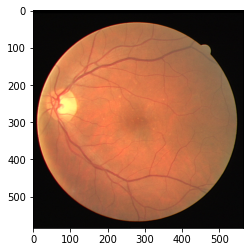

In [40]:
t = test_dataset[0]
t['mask'].shape
p1 = './datasets/training/1st_manual/21_manual1.gif'
p1 = Image.open(p1)
print(p1.size)
p1 = np.asarray(p1)
# p1 = ToTensor()(p1)
print(p1.shape)

p2 = './datasets/training/images/21_training.tif'
p2 = Image.open(p2)
print(p2.size)
p2 = np.asarray(p2)
print(p2.shape)
plt.imshow(p2)
plt.show()

get one batch

In [41]:
batch = next(iter(test_loader))
image_name = batch['name'][0]  # batch 0
image = batch['image']  # torch.Size([1, 3, 584, 565]) BCHW
mask = batch['mask']  # torch.Size([1, 584, 565]) BHW
mask.shape  #  由于Dataset中mask是先从PIL转为numpy再转为Tensor，所以其缺少C维度

torch.Size([1, 584, 565])

load ground truth

In [42]:
image_id = image_name.split('_')[0]  # str
gt_file = os.path.join(gt_dir, image_id+'_manual1.gif')
assert os.path.exists(gt_file), 'grond truth {} does not exist'.format(gt_file)
gt = ToTensor()(Image.open(gt_file))  # torch.Size([1, 584, 565]) in CHW
gt = gt.squeeze()
gt.shape

torch.Size([584, 565])

Visualization

torch.Size([1, 3, 584, 565]) in B C H W
01_test
torch.Size([584, 565]) in H W


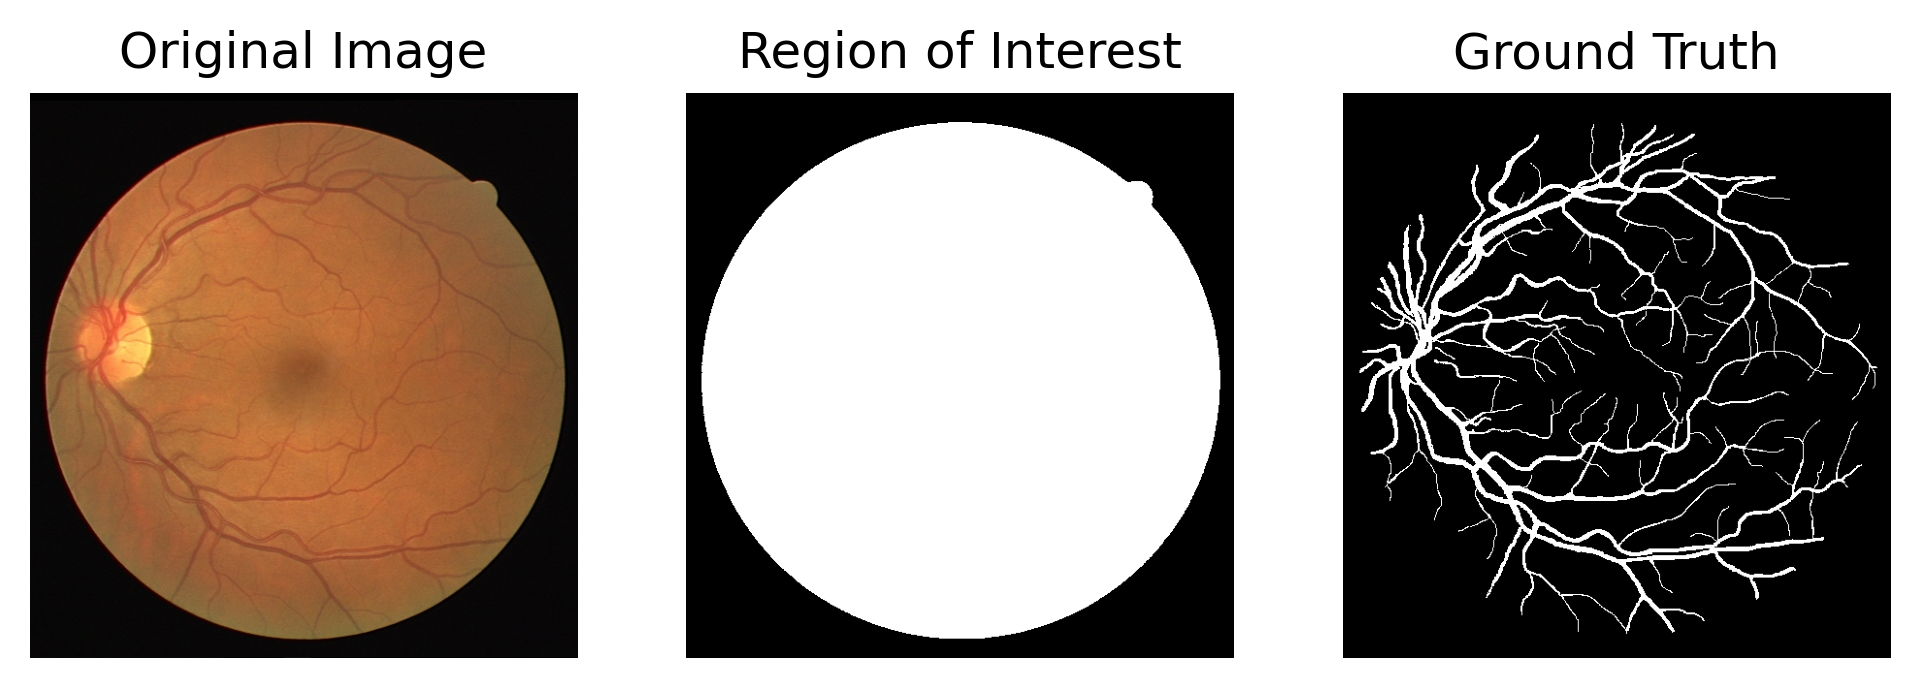

In [43]:
print(image.shape, 'in B C H W')
print(image_name)
print(gt.shape, 'in H W')

img_ndarray = image.permute(0, 2, 3, 1).squeeze().numpy()
mask_ndarray = mask.permute(1, 2, 0).squeeze().numpy()
gt_ndarray = gt.numpy()

fig = plt.figure(figsize=[8, 10], dpi=300)
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_ndarray)
ax1.axis('off')
ax1.set_title('Original Image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(mask_ndarray, cmap='gray')
ax2.axis('off')
ax2.set_title('Region of Interest')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(gt, cmap='gray')
ax3.axis('off')
ax3.set_title('Ground Truth')
plt.show()

In [44]:
print('Now the shape is: ')
print('Origin Image: ', image.shape, 'in B C H W')
print('Ground Truth', gt.shape, 'in H W')

Now the shape is: 
Origin Image:  torch.Size([1, 3, 584, 565]) in B C H W
Ground Truth torch.Size([584, 565]) in H W


In [45]:
with torch.no_grad():
    output = net(image)  # torch.Size([1, 2, 584, 565]) BCHW
    pred = F.one_hot(output.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
    pred = pred[0, 1, ...]
    assert gt.shape == pred.shape, "the shape of ground true {} and predict {} should be the same".format(gt.shape, pred.shape)

Visualize the distribution in the output

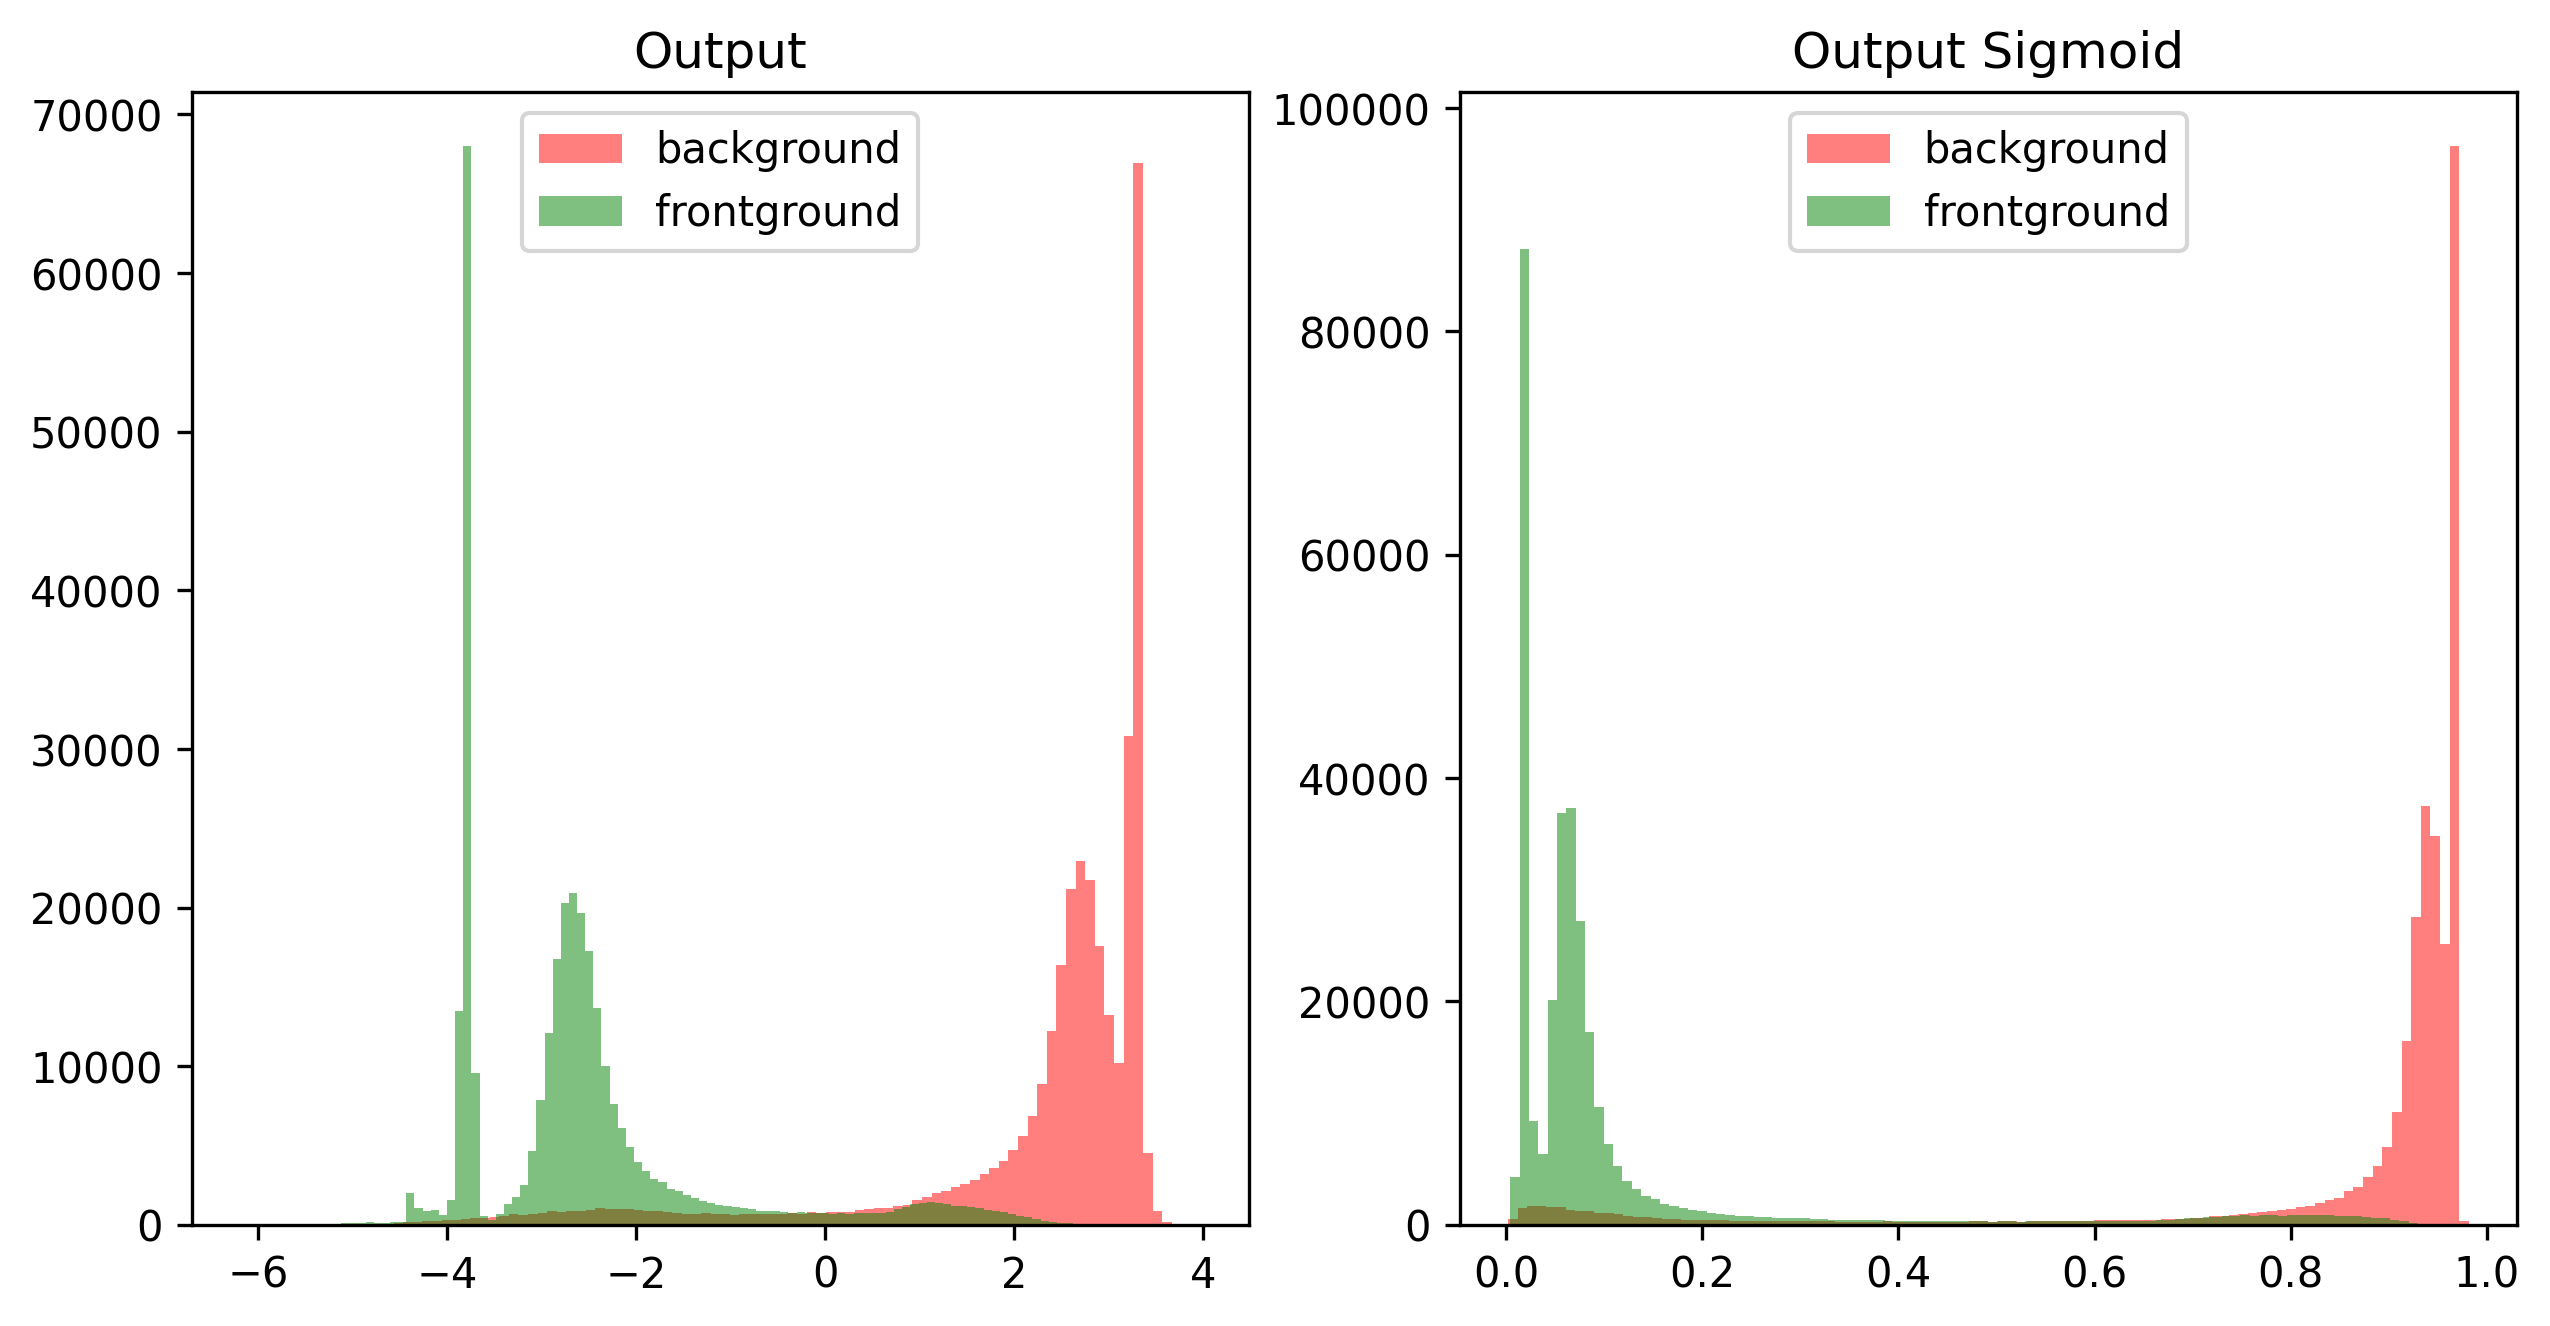

In [48]:
prob0 = output[0, 0, ...]
prob1 = output[0, 1, ...]

fig = plt.figure(2, figsize=[10, 5], dpi=300)
ax1 = fig.add_subplot(1,2,1)
ax1.hist(prob0.flatten().numpy(), label='background', bins=100, color = 'red', alpha = 0.5)
ax1.hist(prob1.flatten().numpy(), label='frontground', bins=100, color = 'Green', alpha = 0.5)
ax1.legend(loc= 'upper center')
ax1.set_title('Output')

prob0 = torch.sigmoid(prob0)
prob1 = torch.sigmoid(prob1)
ax2 = fig.add_subplot(1,2,2)
ax2.hist(prob0.flatten().numpy(), label='background', bins=100, color = 'red', alpha = 0.5)
ax2.hist(prob1.flatten().numpy(), label='frontground', bins=100, color = 'Green', alpha = 0.5)
ax2.legend(loc =  'upper center')
ax2.set_title('Output Sigmoid')
plt.show()

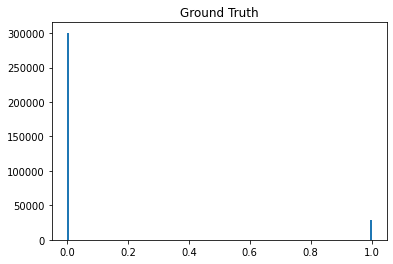

In [49]:
fig, ax = plt.subplots()
ax.hist(gt.flatten().numpy(), bins=150)
ax.set_title('Ground Truth')
plt.show()

Test torchmetrics

In [2]:
target = torch.tensor([[0, 1, 0], [1, 0, 1], [1, 0, 1]])
preds = torch.tensor([[0.1, 0.9, 0], [0.3, 0.1, 0.6], [0.2, 0.6, 0.3]])

In [3]:
TN, FP, FN, TP = BinaryConfusionMatrix(preds>0.5, target)
print(TN, FP, FN, TP)

tensor(3) tensor(1) tensor(3) tensor(2)


In [11]:
print('manual compute:', (TP + TN) / (TP + FP + FN + TN))
accuracy = Accuracy()
accuracy(preds, target)

manual compute: tensor(0.5556)


tensor(0.5556)

In [12]:
print('manual compute:', TP/(TP+FP))
precision = Precision(average='micro')
precision(preds, target)

manual compute: tensor(0.6667)


tensor(0.6667)

In [15]:
print('manual compute:', TP / (TP + FN) )
recall = Recall()
recall(preds, target)

manual compute: tensor(0.4000)


tensor(0.4000)

In [18]:
print('manual compute:',  TN / (TN + FP) )
specificity = Specificity()
specificity(preds, target)

manual compute: tensor(0.7500)


tensor(0.7500)

In [35]:
roc = ROC(pos_label=1)
fpr, tpr, thresholds = roc(preds, target)
print(fpr,'\n', tpr, '\n', thresholds)

BinaryConfusionMatrix(preds>=0., target)
# TN, FP, FN, TP

tensor([0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.7500, 1.0000]) 
 tensor([0.0000, 0.2000, 0.4000, 0.8000, 1.0000, 1.0000, 1.0000]) 
 tensor([1.9000, 0.9000, 0.6000, 0.3000, 0.2000, 0.1000, 0.0000])


(tensor(0), tensor(4), tensor(0), tensor(5))

Apply torchmetrics

tensor(0.9638) tensor(0.8446) tensor(0.7276) tensor(0.9869)
tensor([0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]) 
 tensor([0.0000e+00, 3.3967e-05, 6.7935e-05,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00]) 
 tensor([ 4.1389,  3.1389,  3.1322,  ..., -5.4495, -5.4513, -5.4621])


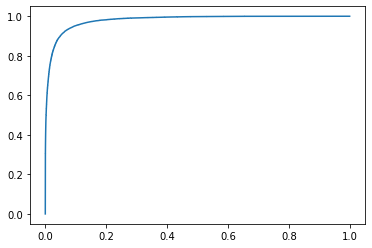

In [79]:
accuracy = Accuracy(threshold=0.0)
precision = Precision(average='micro', threshold=0.0)
recall = Recall(threshold=0.0)
specificity = Specificity(threshold=0.0)
roc = ROC(pos_label=1)

prob = output[0, 1, ...]

acc = accuracy(prob, gt.bool())
prc = precision(prob, gt.bool())
rcl = recall(prob, gt.bool())
spc = specificity(prob, gt.bool())
fpr, tpr, thresholds = roc(prob, gt.bool())

print(acc, prc, rcl, spc)
print(fpr,'\n', tpr, '\n', thresholds)

fig, ax = plt.subplots()
ax.plot(fpr.numpy(), tpr.numpy())
plt.show()

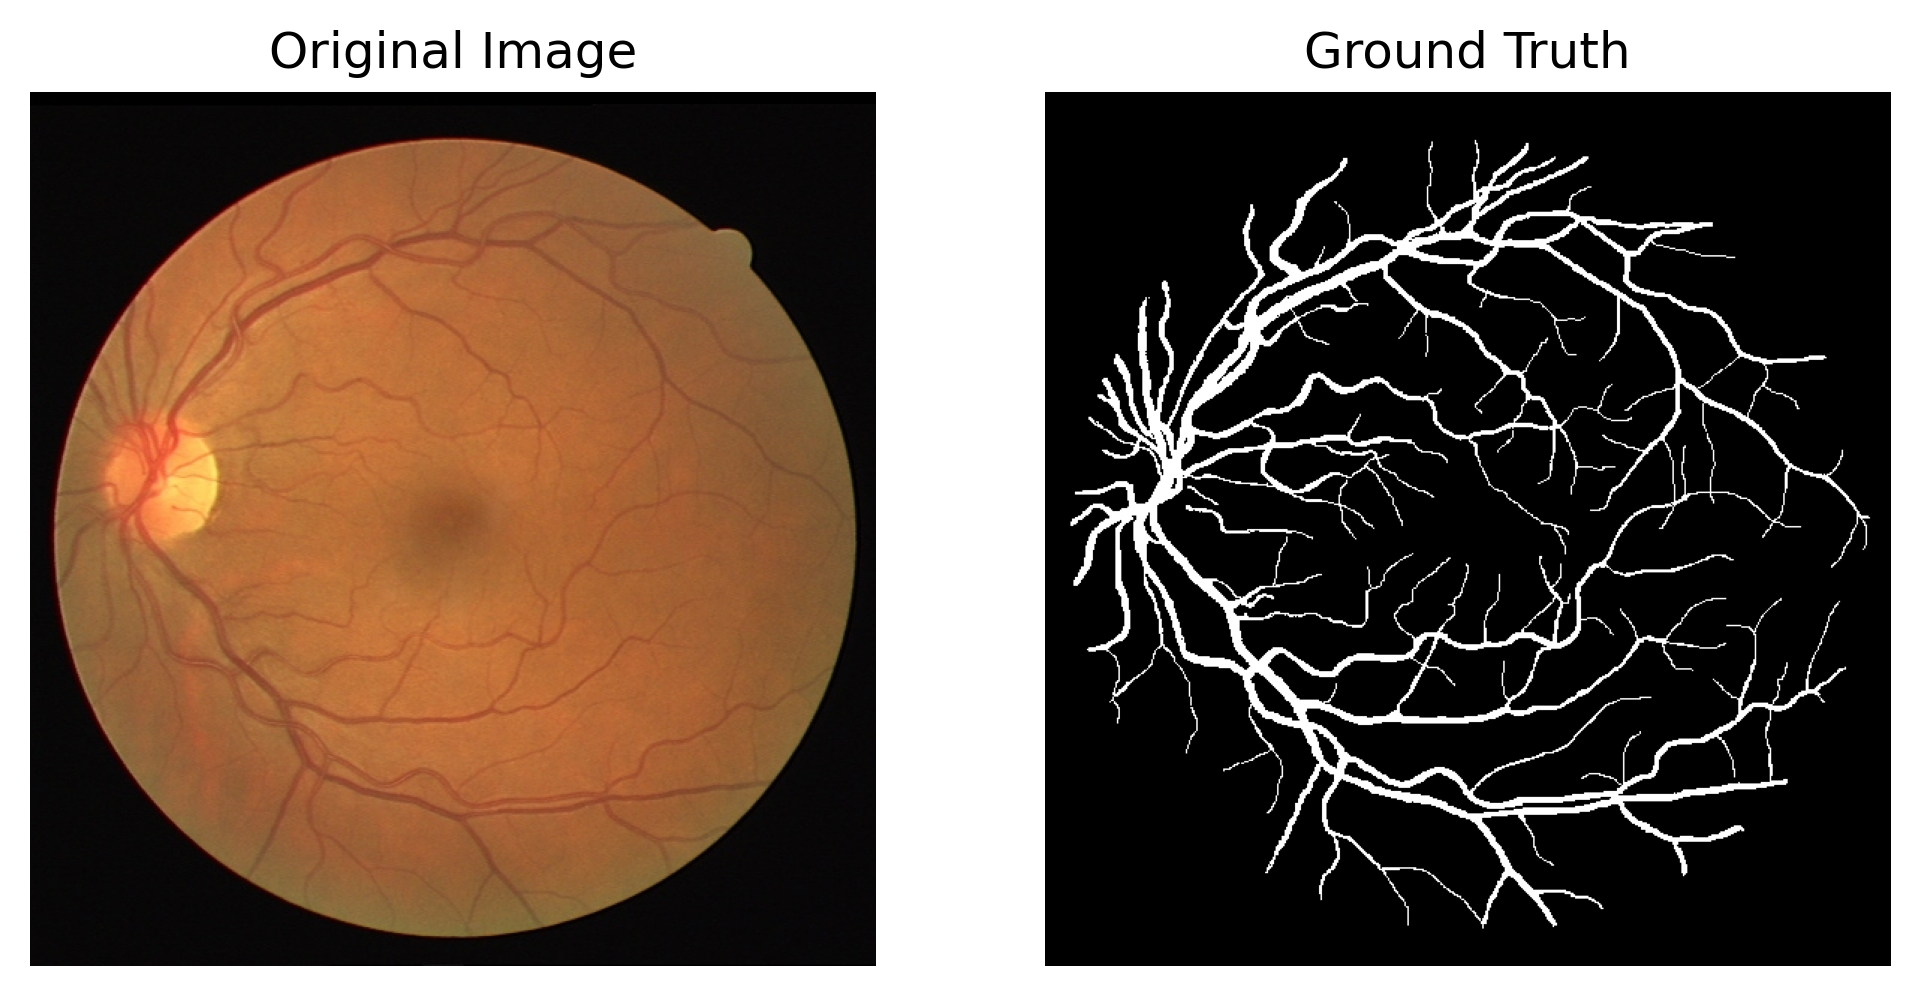

In [95]:
test_dataset = DriveDataset(img_dir, gt_dir, scale=1, mask_suffix='_manual1')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=2)
weight_file = './checkpoints/checkpoint_epoch20.pth'
assert os.path.exists(weight_file), "Weight file {} does not exist, " \
                                    "you can download it from ...".format(weight_file)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=3, n_classes=2, bilinear=False)
net.load_state_dict(torch.load(weight_file, map_location=device))

batch = next(iter(test_loader))
image_name = batch['name']  # batch 0
image = batch['image']  # torch.Size([2, 3, 584, 565]) BCHW
gt = batch['mask']  # torch.Size([2, 584, 565]) BHW

img_ndarray = image.permute(0, 2, 3, 1)[0].numpy()
gt_ndarray = gt[0].numpy()

fig = plt.figure(figsize=[8, 10], dpi=300)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_ndarray)
ax1.axis('off')
ax1.set_title('Original Image')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(gt_ndarray, cmap='gray')
ax2.axis('off')
ax2.set_title('Ground Truth')
plt.show()

In [98]:
with torch.no_grad():
    output = net(image)  # torch.Size([1, 2, 584, 565]) BCHW

In [131]:
prob = output[:, 1, ...]
assert prob.shape == gt.shape

accuracy = Accuracy(threshold=0.0)
precision = Precision(average='micro', threshold=0.0)
recall = Recall(threshold=0.0)
specificity = Specificity(threshold=0.0)
roc = ROC(pos_label=1)

acc = accuracy(prob, gt.bool())
prc = precision(prob, gt.bool())
rcl = recall(prob, gt.bool())
spc = specificity(prob, gt.bool())

print(acc, prc, rcl, spc)

fpr, tpr, thresholds = roc(prob, gt.bool())
print(fpr,'\n', tpr, '\n', thresholds)

D:\software\anaconda\anacondasoftware\envs\torchCPU\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor(0.9626) tensor(0.8794) tensor(0.7068) tensor(0.9897)
tensor([0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]) 
 tensor([0.0000e+00, 1.5815e-05, 3.1631e-05,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00]) 
 tensor([ 4.1267,  3.1267,  3.0727,  ..., -5.7281, -5.7284, -5.7459])


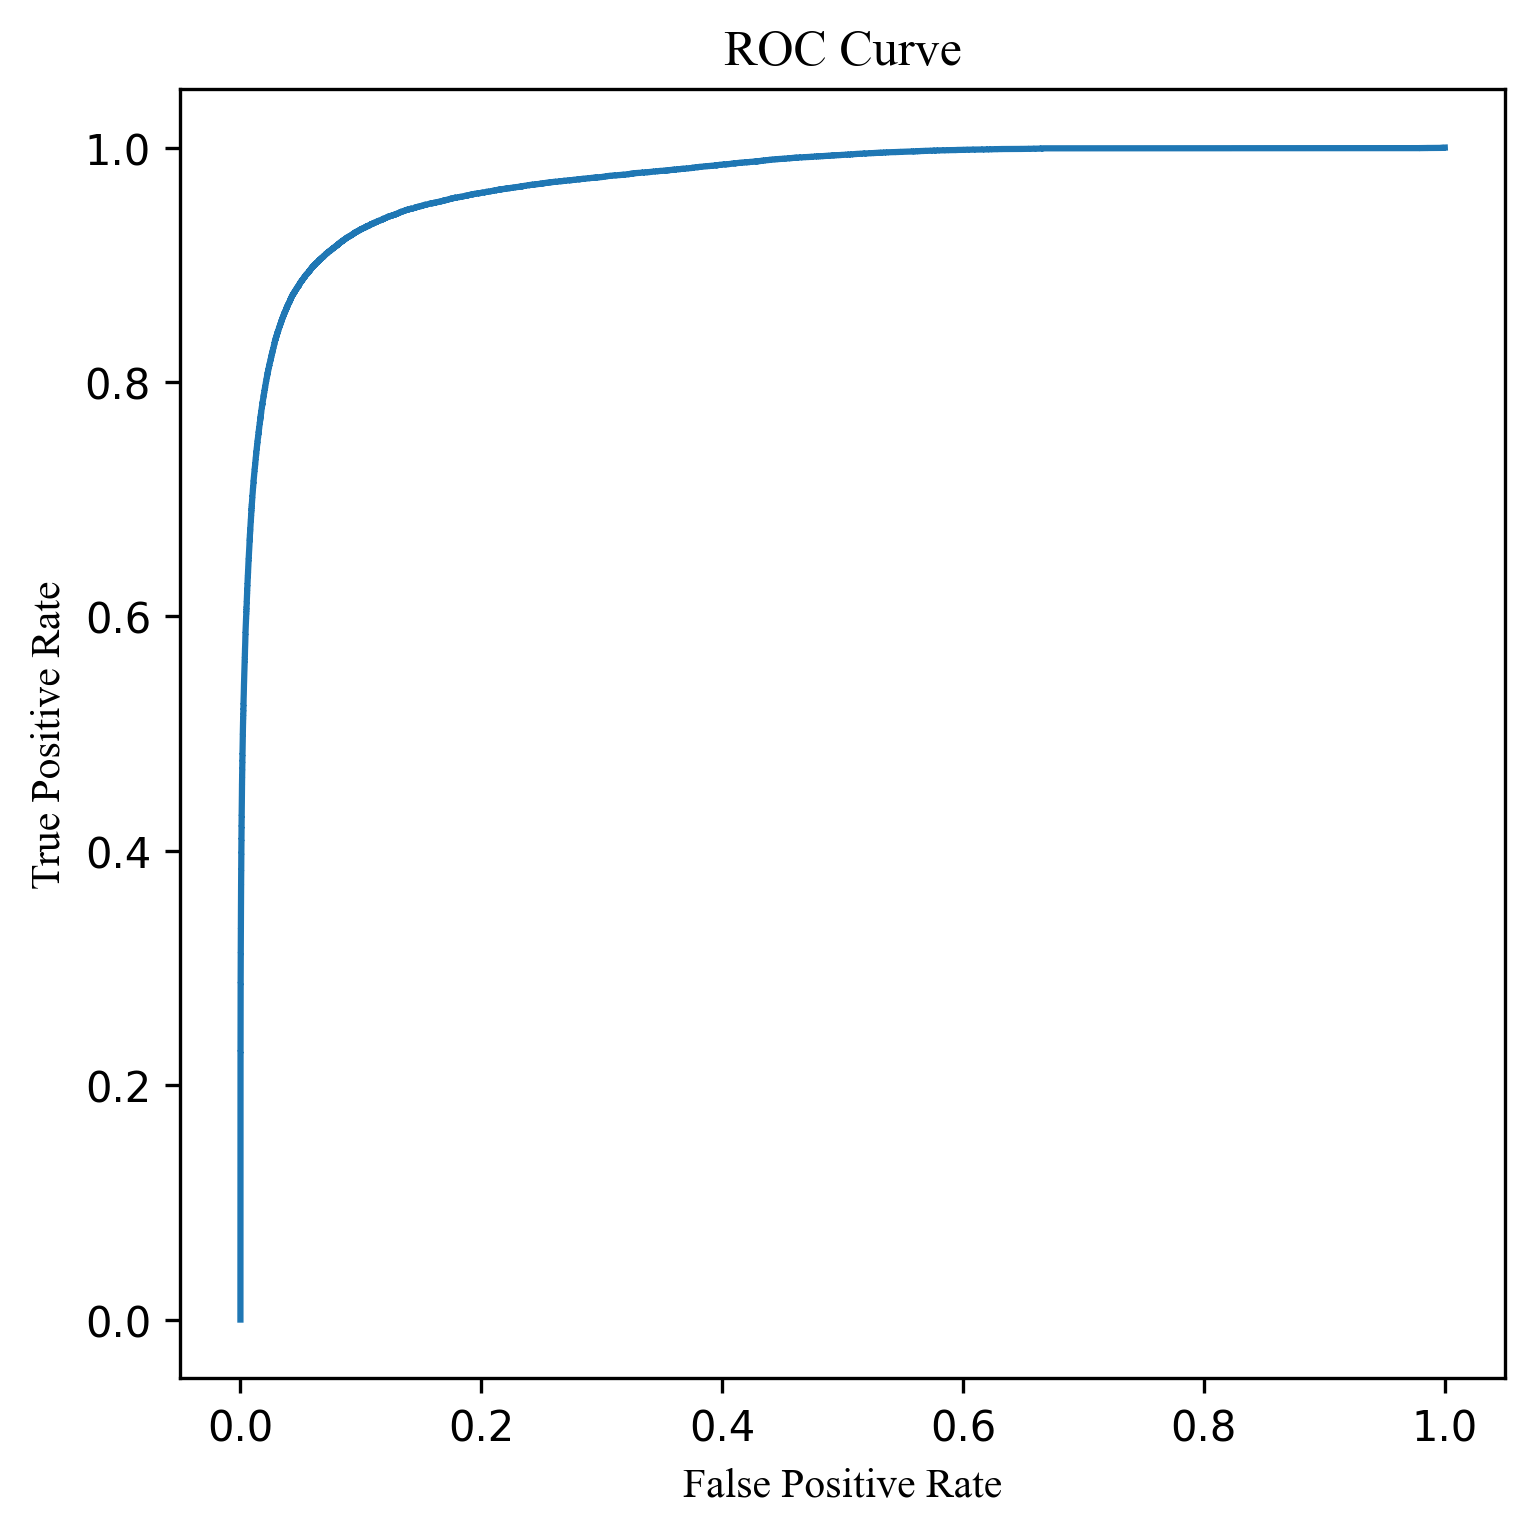

In [151]:
TNRfont = {'fontname':'Times New Roman'}

fig, ax = plt.subplots(figsize=[5,5], dpi=300, layout='constrained')  # a figure with a single Axes
ax.plot(fpr.numpy(), tpr.numpy())
ax.set_xlabel('False Positive Rate', **TNRfont)
ax.set_ylabel('True Positive Rate', **TNRfont)
ax.set_title('ROC Curve', **TNRfont)
# ax.set_ylim(ymin=0, ymax=1)
# ax.set_xlim(xmin=0, xmax=1)
plt.show()

20